# **`Flower Recognition`**

We import the libraries that we'll be using thorughout this notebook.

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import splitfolders

## Dataset

The first thing that we're going to do is analyze our dataset. This dataset was recovered from **[Kaggle](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition?resource=download&select=flowers)**, uploaded from *ALEXANDER MAMAEV*

The dataset contains multiple images from five kind of flowers, including daisy, dandelion, rose, sunflower and tulips.

In [2]:
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
inputFolder = '../data/flowers/'

Image daisy shape: (263, 320, 3)
There are 764 images of daisy
Image dandelion shape: (213, 320, 3)
There are 1052 images of dandelion
Image rose shape: (240, 179, 3)
There are 784 images of rose
Image sunflower shape: (330, 500, 3)
There are 733 images of sunflower
Image tulip shape: (209, 320, 3)
There are 984 images of tulip


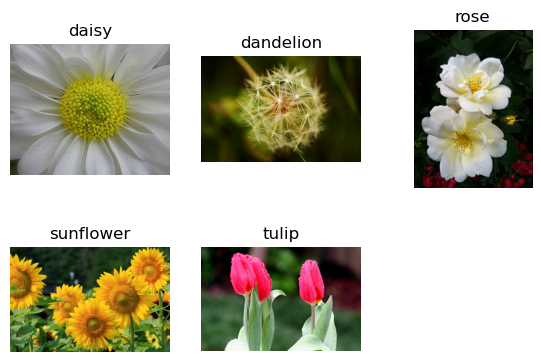

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
for i, cls in enumerate(classes):
  img_path = os.listdir(inputFolder + f'/{cls}/')[0]
  img = image.load_img(inputFolder + f'/{cls}/' + img_path)
  print(f'Image {cls} shape: {image.img_to_array(img).shape}')
  print(f'There are {len(os.listdir(inputFolder + f"/{cls}/"))} images of {cls}')
  axes[i // 3, i % 3].imshow(img)
  axes[i // 3, i % 3].set_title(cls)
  axes[i // 3, i % 3].axis("off")
plt.tight_layout()

Now that we've seen how the flowers and our dataset looks, it's time to load our dataset to train our model. For this, we will generate the validation, training, and testing dataset.

In [4]:
output_dir = '../data/'
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [5]:
splitfolders.ratio(inputFolder, output=output_dir, seed=1337, ratio=(train_ratio, val_ratio, test_ratio))

In [6]:
train_dir = '../data/train/'
val_dir = '../data/val/'
test_dir = '../data/test/'

In [7]:
train_datagen = ImageDataGenerator(
        rescale=1./255, rotation_range=40,
        width_shift_range=0.2, height_shift_range=0.2,
        shear_range=0.2, zoom_range=0.2, 
        horizontal_flip=True,fill_mode='nearest'
    )

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
print('Train:')
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224), batch_size=32,
        class_mode='categorical',
        seed=123
    )

Train:
Found 3452 images belonging to 5 classes.


In [9]:
print('Val:')
val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224), batch_size=32,
        class_mode='categorical',
        seed=123
    )

Val:
Found 863 images belonging to 5 classes.


In [10]:
print('Test:')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224), batch_size=32,
        class_mode='categorical',
        seed=123
    )

Test:
Found 438 images belonging to 5 classes.


## Developing our model

For our model, we'll use transfer learning by loading the pretrained architecture Mobilnet.

In [11]:
IMG_SHAPE = (224, 224, 3)

In [12]:
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
pre_trained_model.trainable = False

Now that we've loaded the pre-trained architecture, we'll add the proper settings for our classification task.


In [19]:
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(pre_trained_model.output)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(len(classes), activation='softmax')(x)

In [20]:
model = tf.keras.Model(inputs=pre_trained_model.input, outputs=predictions)

In [21]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [22]:
starting_lr = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=starting_lr), loss='categorical_crossentropy', metrics=['accuracy'])

## Callbacks

Now that we've declared our model, we'll generate callbacks to help during the training of our model

In [24]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, min_lr=0.00001)

## Training 🦾

Now that we've loaded our data and designed the architecture of our model, its time to train and analyze the results

In [25]:
BATCH_SIZE = 32
train_size = train_generator.samples
val_size = val_generator.samples
epochs = 30

In [26]:
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, steps_per_epoch=train_size//BATCH_SIZE, validation_steps=val_size//BATCH_SIZE, callbacks=[early_stop, reduce_lr])

Epoch 1/30
107/107 [==============================] - 160s 1s/step - loss: 1.4535 - accuracy: 0.5819 - val_loss: 0.6076 - val_accuracy: 0.7981 - lr: 0.0100
Epoch 2/30
107/107 [==============================] - 141s 1s/step - loss: 0.7931 - accuracy: 0.6912 - val_loss: 0.4625 - val_accuracy: 0.8534 - lr: 0.0100
Epoch 3/30
107/107 [==============================] - 140s 1s/step - loss: 0.7331 - accuracy: 0.7351 - val_loss: 0.5137 - val_accuracy: 0.8173 - lr: 0.0100
Epoch 4/30
107/107 [==============================] - 140s 1s/step - loss: 0.6593 - accuracy: 0.7602 - val_loss: 0.4027 - val_accuracy: 0.8798 - lr: 0.0100
Epoch 5/30
107/107 [==============================] - 138s 1s/step - loss: 0.6388 - accuracy: 0.7673 - val_loss: 0.4253 - val_accuracy: 0.8690 - lr: 0.0100
Epoch 6/30
107/107 [==============================] - 138s 1s/step - loss: 0.5761 - accuracy: 0.7789 - val_loss: 0.3711 - val_accuracy: 0.8846 - lr: 0.0100
Epoch 7/30
107/107 [==============================] - 135s 1s/st

## Graphs 📈📉

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

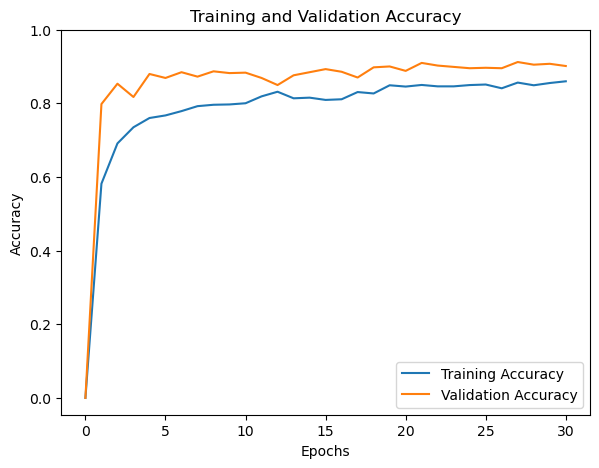

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(acc, label='Training Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylim([min(plt.ylim()), 1])
axs[0].set_title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

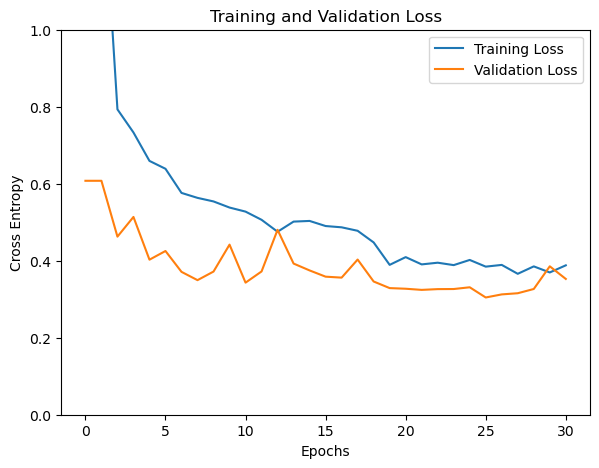

In [29]:
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epochs')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')

## Evaluation 🔬📊

In [30]:
Loss, Accuracy = model.evaluate(test_generator)

print("    Train Loss: {:.5f}".format(Loss))
print("Train Accuracy: {:.2f}%".format(Accuracy * 100))

14/14 [==============================] - 14s 994ms/step - loss: 0.3980 - accuracy: 0.8950
    Train Loss: 0.39795
Train Accuracy: 89.50%


### Confusion Matrix

In [31]:
real_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [32]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

14/14 [==============================] - 14s 961ms/step


<AxesSubplot:>

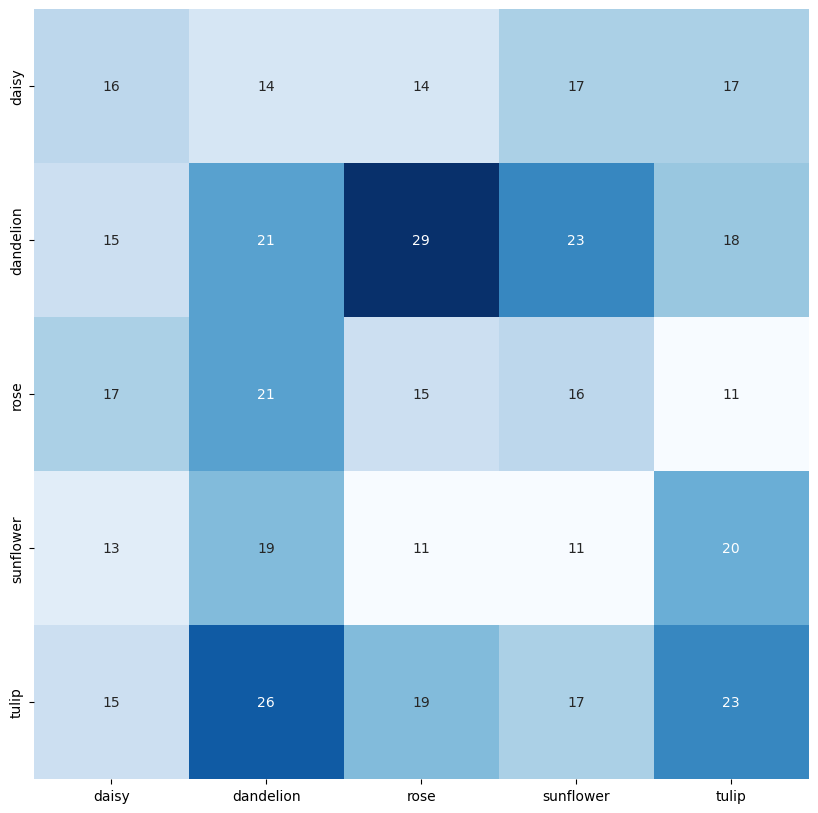

In [33]:
cm = confusion_matrix(real_classes, predicted_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)

In [34]:
model.save('flowers_model.h5')